Our first [public data set](http://deeplearnphysics.org/DataChallenge/#ChallengeClassification) is available! We are very excited for this 1st step to have public data set with [training tutorials](http://deeplearnphysics.org/Blog/tutorial_summary.html). This notebook is an announcement + browsing of the file contents. This may be a useful guide before jumping into the tutorial. Since this notebook is a bit lengthy, here's an outline of what's covered.

1. [Overall summary of sample generation configuration](#overview)
2. [Exploring file contents](#file_contents)
3. [Example image dump](#image_dump) (data analysis)
4. [Particle-wise event fraction](#event_fraction) (data analysis)
5. [Energy and momentum distribution](#kinematics) (data analysis)
6. [Image filtering effect](#filter_effect) (data analysis)

In [2]:
from __future__ import print_function
import ROOT
from ROOT import TChain
from larcv import larcv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a name="overview"></a>
## Conditions to make the samples

Here's the big picture:

* All files (train, test, and tutorial files) contain single-particle events.
    * This means each 2D image contain only 1 particle.
* There are five particle types including electron, gamma ray, muon, pion, and proton.
* An event fraction per particle type is equal for all samples.
* A particle's generation point is uniformly distributed within 5.12 m cubic volume.
* A particle's (momentum) direction is isotropic.
* A particle's momentum is uniformly distributed in the range specified per type.
    * electrons ... 35.5 to 800 MeV/c
    * gamma rays ... 35 to 800 MeV/c
    * muons ... 90 to 800 MeV/c
    * pions ... 105 to 800 MeV/c
    * protons ... 275 to 800 MeV/c
* 2.56 m cubic 3D volume is chosen to maximize the particle's trajectory within the volume and recorded in the file.
* 2D images are created as 2D projections (xy, yz, zx) of the 3D data
    * These are 3 channels of 2D images in each file.
* Events that contain any 2D projection **image with less than 10 non-zero pixels are filtered out.**
    *This is to remove empty and almost empty images from the set.

<a name="file_contents"></a>
## Exploring the contents
I think the file description is best done with the data. So let's explore them in this notebook. This also serves as an example of how to browse through `larcv` data products! We use this [test file](http://deeplearnphysics.org/DataChallenge/#ChallengeClassification) which I already downloaded in this directory. Let's check what data products are in the file. But **before going further**, please go over [this tutorial](http://deeplearnphysics.org/Blog/tutorials/tutorial-02.html) if you have not done so!


In [3]:
ROOT.TFile.Open('test_40k.root').ls()

TFile**		test_40k.root	
 TFile*		test_40k.root	
  KEY: TTree	image2d_data_tree;1	data tree
  KEY: TTree	particle_mctruth_tree;1	mctruth tree


As described in the linked tutorial, TTree names tell us what they are: we got `image2d` and `particle` data products with "data" and "mctruth" instance labels. `image2d` is, as its name suggests, 2D image. 

<a name="image_dump"></a>
## Closer look: image
Let's take a peek of it using [TChain](https://root.cern.ch/root/html526/TChain.html), the same technique introduced in the linked tutorial.

40000 entries found!
Object type: <ROOT.larcv::EventImage2D object at 0x7fbb38918600>


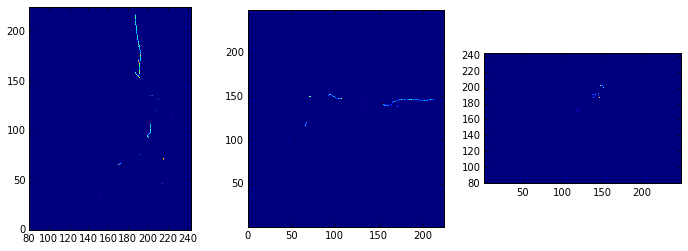

In [4]:
from larcv import larcv

# Create TChain, count # of entries
chain_image2d = ROOT.TChain('image2d_data_tree')
chain_image2d.AddFile('test_40k.root')
print(chain_image2d.GetEntries(),'entries found!')

# Get a specific event (first entry)
chain_image2d.GetEntry(0)
cpp_object = chain_image2d.image2d_data_branch
print('Object type:',cpp_object)

# Get std::vector<larcv::Image2D>
image2d_array = cpp_object.as_vector()
# Dump images
fig, axes = plt.subplots(1, image2d_array.size(), figsize=(12,4), facecolor='w')
for index,image2d in enumerate(image2d_array):
    image2d_numpy = larcv.as_ndarray(image2d)
    axes[index].imshow(image2d_numpy, interpolation='none',cmap='jet')
    # Find bounds for non-zero pixels + padding of 5 pixels
    nz_pixels=np.where(image2d_numpy>0.0)
    ylim = (np.min(nz_pixels[0])-5,np.max(nz_pixels[0])+5)
    xlim = (np.min(nz_pixels[1])-5,np.max(nz_pixels[1])+5)
    # Adjust for allowed image range
    ylim = (np.max((ylim[0],0)), np.min((ylim[1],image2d_numpy.shape[1]-1)))
    xlim = (np.max((xlim[0],0)), np.min((xlim[1],image2d_numpy.shape[0]-1)))
    # Set range
    axes[index].set_ylim(ylim)
    axes[index].set_xlim(xlim)
plt.show()

Looks like this is an electron EM-shower. Why electron and not gamma ray? That's because, to my eyes, this looks like low dE/dX at the beginning of the shower trunk. But to check if I am right or not, we have to access simulation information (coming up next)!

<a name="event_fraction"></a>
## Closer look: particle (label)
We can look at `particle` information in the file, which you will use to generate a _label_ for image classification training, to check if the image we saw was electron or not.

In [5]:
# Create TChain, count # of entries
chain_particle = ROOT.TChain('particle_mctruth_tree')
chain_particle.AddFile('test_40k.root')
print(chain_image2d.GetEntries(),'entries found!')

# Get a specific event (first entry)
chain_particle.GetEntry(0)
cpp_object = chain_particle.particle_mctruth_branch
print('Object type: {}\n'.format(str(cpp_object)))

# Dump particle information
print('Checking particle information for 1st entry...')
for particle in cpp_object.as_vector():
    print('PDG Code: {}'.format(particle.pdg_code()))
    print('Initial energy: {:.3} GeV'.format(particle.energy_init()))

40000 entries found!
Object type: <ROOT.larcv::EventParticle object at 0x7fbb379dc180>

Checking particle information for 1st entry...
PDG Code: 11
Initial energy: 0.138 GeV


[PDG code](http://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf) 11 corrsponds to electron! So I guessed it right :)

<a name="kinematics"></a>
## Closer look: kinematics
Next, let's look at the fraction of each particle type and their energy distributions for fun. We first make `pandas.DataFrame` with numpy arrrays for simple analysis and plotting.

In [6]:
pdg_array      = np.zeros([chain_particle.GetEntries()],dtype=np.int32)
energy_array   = np.zeros([chain_particle.GetEntries()],dtype=np.float64)
momentum_array = np.zeros([chain_particle.GetEntries()],dtype=np.float64)

for index in range(chain_particle.GetEntries()):
    chain_particle.GetEntry(index)
    particle = chain_particle.particle_mctruth_branch.as_vector().front()
    pdg = int(particle.pdg_code())
    total_energy   = particle.energy_init() * 1000.
    kinetic_energy = total_energy - larcv.ParticleMass(pdg)
    momentum = np.sqrt(np.power(total_energy,2) - np.power(larcv.ParticleMass(pdg),2))
    
    pdg_array[index]      = pdg
    energy_array[index]   = kinetic_energy
    momentum_array[index] = momentum
    
    #if momentum > 800:
    #    print(pdg,kinetic_energy,momentum)

import pandas as pd
df = pd.DataFrame(data={'pdg' : pdg_array, 'energy' : energy_array, 'momentum' : momentum_array})

List of particles and their event counts:

In [7]:
pdg_list, pdg_counts = np.unique(df.pdg.values,return_counts=True)

print('PDGs found: {}'.format(pdg_list))
print('PDG counts: {}'.format(pdg_counts))

PDGs found: [  11   13   22  211 2212]
PDG counts: [8000 8000 8000 8000 8000]


... as expected, we have equal partition of 5 particle types. Check the range of momentum per particle type:

In [8]:
PDG2NAME = {11   : 'electron',
            22   : 'gamma',
            13   : 'muon',
            211  : 'pion',
            2212 : 'proton'}
for pdg in pdg_list:
    sub_df = df.query('pdg=={}'.format(pdg))
    min_value = sub_df.momentum.values.min()
    max_value = sub_df.momentum.values.max()
    print('{:10s} momentum range: {:.3g} => {:.3g} MeV/c'.format(PDG2NAME[pdg], min_value, max_value))

electron   momentum range: 35.6 => 800 MeV/c
muon       momentum range: 90 => 800 MeV/c
gamma      momentum range: 35.1 => 800 MeV/c
pion       momentum range: 105 => 800 MeV/c
proton     momentum range: 276 => 800 MeV/c


This is also as expected from the prescription. Next is more interesting: plot energy distributions of gamma ray and muon

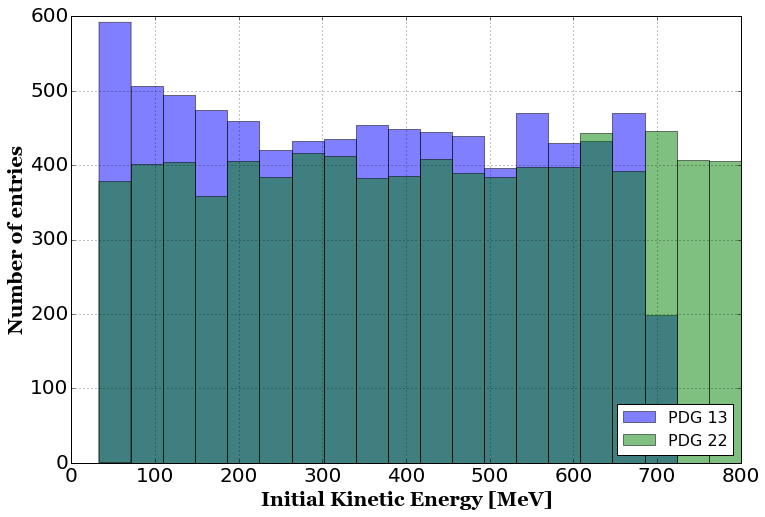

In [9]:
fig, ax = plt.subplots(figsize=(12,8),facecolor='w')

pdg_list = [13,22]
sub_df = df.query('pdg in {}'.format(pdg_list))
min_value = sub_df.energy.values.min()
max_value = sub_df.energy.values.max()

for pdg in pdg_list:
    pdg_df = sub_df.query('pdg == {}'.format(pdg))
    values = pdg_df.energy.values
    plt.hist(values, bins=20, range=(min_value,max_value), label='PDG {}'.format(pdg), alpha=0.5)

plt.tick_params(labelsize=20)
plt.grid(True,which='both')
plt.xlabel('Initial Kinetic Energy [MeV]',fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel('Number of entries',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=4)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
    
plt.show()

We see two features here:
* Muon appears to have non-uniform kinetic energy distribution while that of gamma ray appears to be uniform.
* Muon kinetic energy distribution falls off beyond (about) 700 MeV while that of gamma ray continues up to 800 MeV

The first point is due to the fact that particles are generated **uniformly in momentum space** and not in kinetic energy. The non-negligible muon mass (105.6 MeV) in the generated momentum range causes its kinetic energy to be non-uniform. On the other hand, gamma ray has 0 mass (no please don't ask "what if photons are massive..." question). That means momentum = energy, and hence you see a _uniform kinetic energy_ distribution ranging up to 800 MeV.

Let's actually plot the momentum distribution.

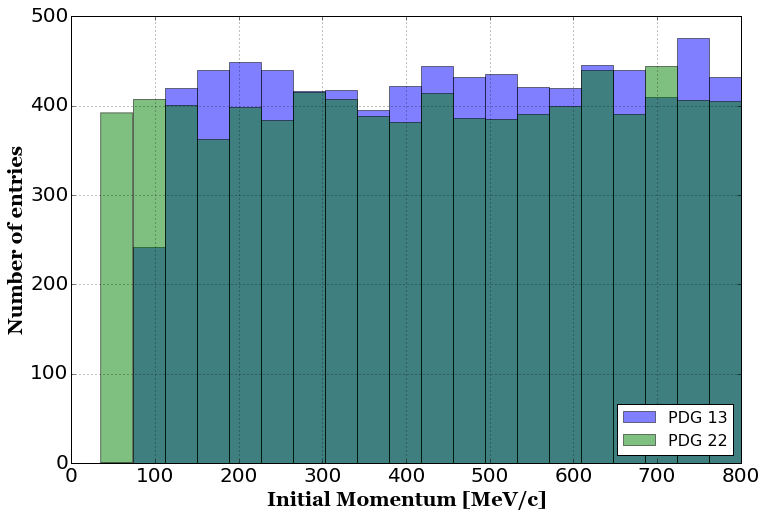

In [10]:
fig, ax = plt.subplots(figsize=(12,8),facecolor='w')

pdg_list = [13,22]
sub_df = df.query('pdg in {}'.format(pdg_list))
min_value = sub_df.momentum.values.min()
max_value = sub_df.momentum.values.max()

for pdg in pdg_list:
    pdg_df = sub_df.query('pdg == {}'.format(pdg))
    values = pdg_df.momentum.values
    plt.hist(values, bins=20, range=(min_value,max_value), label='PDG {}'.format(pdg), alpha=0.5)

plt.tick_params(labelsize=20)
plt.grid(True,which='both')
plt.xlabel('Initial Momentum [MeV/c]',fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel('Number of entries',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=4)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
    
plt.show()

Which looks _almost_ perfect, except there's a drop in the 1st bin for muon. This is a binning effect. Remember the momentum range of muon is set to 90 to 800 MeV/c. If we are to add this condition in our analysis so that we remove the binning effect, we can see a uniform momentum distribution.

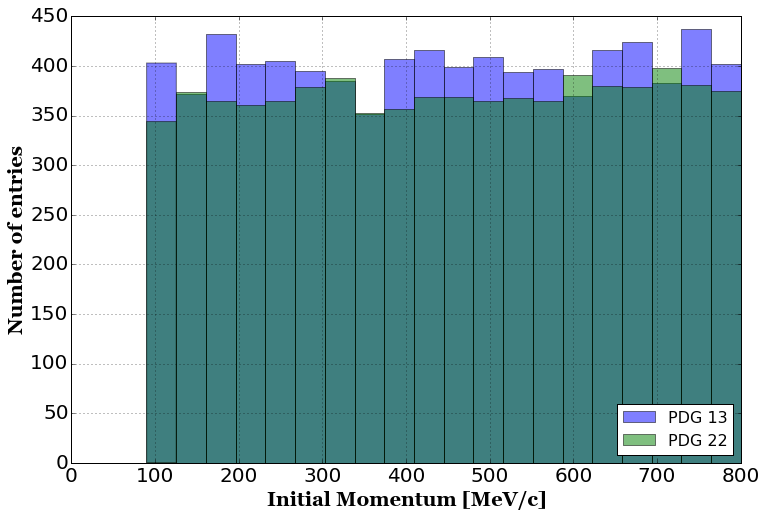

In [11]:
fig, ax = plt.subplots(figsize=(12,8),facecolor='w')

pdg_list = [13,22]
sub_df = df.query('pdg in {} and momentum > 90'.format(pdg_list))
min_value = sub_df.momentum.values.min()
max_value = sub_df.momentum.values.max()

for pdg in pdg_list:
    pdg_df = sub_df.query('pdg == {}'.format(pdg))
    values = pdg_df.momentum.values
    plt.hist(values, bins=20, range=(min_value,max_value), label='PDG {}'.format(pdg), alpha=0.5)

plt.tick_params(labelsize=20)
plt.grid(True,which='both')
plt.xlabel('Initial Momentum [MeV/c]',fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel('Number of entries',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=4)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
    
plt.show()

<a name="filter_effect"></a>
## Closer look: image filtering effect
Recall one of the sample preparation procedures: "_filtering of events for which any 2D image contains less than 10 non-zero pixels_". This was intended to remove (almost) empty images. But it's important to note this condition **filters out a short particle trajectory** which typically means a low energy particle. So this filter biases a particle's energy! 

How significant is this effect? How far a particle travels depends on its type because of [different stopping power](http://pdg.lbl.gov/2014/reviews/rpp2014-rev-passage-particles-matter.pdf). In our energy range, the most severly (and actually only) affected is proton. Let's compare proton and gamma ray momentum distribution.



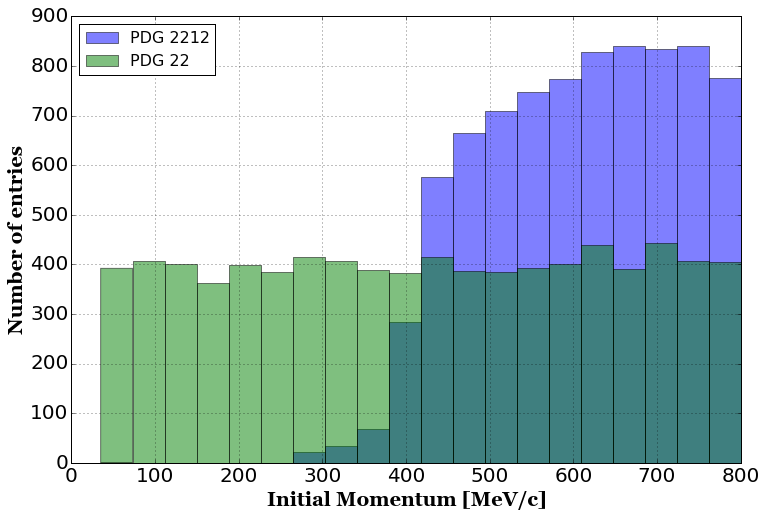

In [12]:
fig, ax = plt.subplots(figsize=(12,8),facecolor='w')

pdg_list = [2212,22]
sub_df = df.query('pdg in {}'.format(pdg_list))
min_value = sub_df.momentum.values.min()
max_value = sub_df.momentum.values.max()

for pdg in pdg_list:
    pdg_df = sub_df.query('pdg == {}'.format(pdg))
    values = pdg_df.momentum.values
    plt.hist(values, bins=20, range=(min_value,max_value), label='PDG {}'.format(pdg), alpha=0.5)

plt.tick_params(labelsize=20)
plt.grid(True,which='both')
plt.xlabel('Initial Momentum [MeV/c]',fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel('Number of entries',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=2)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
    
plt.show()

From earlier analysis in this notebook, we already know that the momentum range of protons in this sample is 276 to 800 MeV/c. In this plot, we can clearly see that proton events are not uniformly distributed over its momentum range. 

So how much protons are affected by "10 pixels filter"? To figure this out, we have to know what 10 pixels correspond to the real world's distance scale. This information is stored in 2D image _meta_ data.

In [13]:
for index,image2d in enumerate(image2d_array):
    print(image2d.meta().dump())

ProjectionID 0 (rows,cols) = (256,256) ... Distance Unit: 1 ... Left Bottom => Right Top     (0,0) => (128,128)

ProjectionID 1 (rows,cols) = (256,256) ... Distance Unit: 1 ... Left Bottom => Right Top     (0,0) => (128,128)

ProjectionID 2 (rows,cols) = (256,256) ... Distance Unit: 1 ... Left Bottom => Right Top     (0,0) => (128,128)



"Distance Unit: 1" means it is in cm scale (`larcv::DistanceUnit_t::kUnitCM`). So each 2D image spans 128cm x 128cm space with 256 x 256 pixels, meaning each pixel corresponds to 0.5 cm in vertical and horizontal size. This means a proton must travel at least 5 cm in all 2D projections, or
$$ x^2+y^2 \geq 25 \text{cm,}$$
$$ y^2+z^2 \geq 25 \text{cm,}$$
$$ z^2+x^2 \geq 25 \text{cm.}$$

Summing them over we find $\sqrt{x^2+y^2+z^2}\geq\sqrt{75/2}\approx6.12$ cm as the minimum distance required for a proton to travel. So what proton energy does this trajectory size corresponds to? Here's a plot I made from [NIST](https://www.nist.gov/pml/stopping-power-range-tables-electrons-protons-and-helium-ions) that shows the proton trajectory size in liquid Argon medium versus its kinetic energy. <img src="imgs/proton_dist.png"> ... from which we can tell $\approx6$ cm corresponds to $\approx80$ MeV. Given the proton mass (938.28 MeV), this corresponds to $\approx419$ MeV/c momentum. **Indeed we see a sharp drop** around that momentum value in the plot above.

### What is affecting the higher momentum range?
Note "$\geq$" sign in the equation we derived above: 6.12 cm is the bare minimum requirement. The actual requirement depends on the initial momentum direction because the projected 2D distances depends on that angle and the projection angles. For instance, a proton with momentum higher than $\approx419$ MeV/c may travel $\approx7.1$ cm from point A $(x,y,z) = (0,0,0)$ [cm] to point B $(4.5,4.5,0)$ [cm]. This satisfies the minimum trajectory length requirement. But it fails to satisfy both $y^2+z^2\geq25$ cm and $z^2+x^2\geq25$, so it won't pass the filter.

In addition, the projection angle also affects projected trajectory size per pixel. 0.5 cm/pixel is the shortest possible case. If a trajectory runs along a diagonal direction of a projected 2D pixel, a requirement of 10 pixels mean 7.1 cm instead of 5 cm, increase of 20% in the required trajectory size.

### Why are there entries in the lower momentum range?
There could be more than one reason. But one thing we definitely expect is a production of other particle types through a proton-nucleus interaction. Recall the filter requires "10 non-zero pixels on each 2D projection planes" but does not specify the particle type. A proton with 70 MeV kinetic energy may be below the threshold to travel long enough, but may produce gamma rays or other particles that can travel longer with lower energy.

So why don't we take a look at them? Let's pick an event with a proton energy below 50 MeV and list them.

In [14]:
sub_df = df.query('pdg==2212 and energy < 50')
print('Found {} entries'.format(sub_df.index.size))
print(sub_df)

Found 31 entries
          energy    momentum   pdg
32020  41.263582  281.310530  2212
32393  49.737159  309.528281  2212
32542  44.556907  292.571902  2212
32850  43.212706  288.024107  2212
34161  46.890996  300.319476  2212
34168  42.130230  284.313542  2212
34355  41.539873  282.271083  2212
34422  39.836204  276.299325  2212
34826  46.279951  298.308904  2212
35047  42.837546  286.743088  2212
35094  46.434549  298.818752  2212
35617  49.411610  308.487557  2212
35871  49.498857  308.766780  2212
36260  48.056076  304.119600  2212
36462  43.842835  290.164104  2212
36599  42.882855  286.898080  2212
36987  46.859598  300.216461  2212
37361  48.909169  306.875088  2212
37446  49.006110  307.186792  2212
37599  48.831407  306.624842  2212
37606  41.447842  281.951462  2212
37618  49.868782  309.948164  2212
38329  46.325785  298.460141  2212
38539  48.387375  305.192368  2212
38578  44.501460  292.385587  2212
38712  46.190251  298.012721  2212
38973  44.025635  290.782224  2212
390

Let's take a look at just 1st projection of the first entry (32020)

40000 entries found!
Object type: <ROOT.larcv::EventImage2D object at 0x7fbb36c3a720>


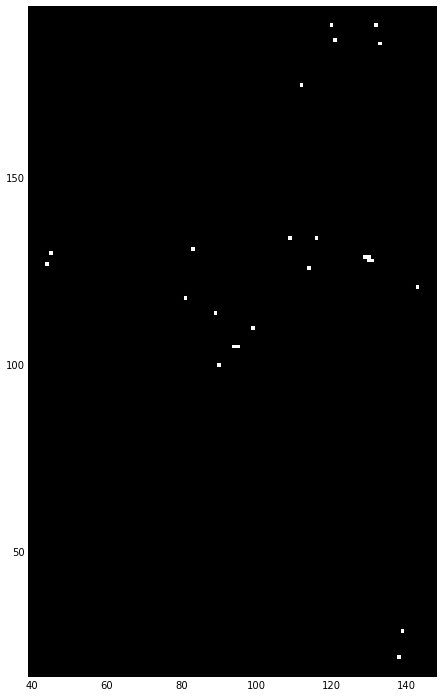

In [15]:
# Create TChain, count # of entries
chain_image2d = ROOT.TChain('image2d_data_tree')
chain_image2d.AddFile('test_40k.root')
print(chain_image2d.GetEntries(),'entries found!')

# Get a specific event (first entry)
chain_image2d.GetEntry(32020)
cpp_object = chain_image2d.image2d_data_branch
print('Object type:',cpp_object)

image2d = cpp_object.as_vector().front()

fig, ax = plt.subplots(figsize=(12,12), facecolor='w')
image2d_numpy = larcv.as_ndarray(image2d)
ax.imshow(image2d_numpy, interpolation='none', vmin=0., vmax=image2d_numpy.mean(), cmap='gray')
# Find bounds for non-zero pixels + padding of 5 pixels
nz_pixels=np.where(image2d_numpy>0.0)
ylim = (np.min(nz_pixels[0])-5,np.max(nz_pixels[0])+5)
xlim = (np.min(nz_pixels[1])-5,np.max(nz_pixels[1])+5)
# Adjust for allowed image range
ylim = (np.max((ylim[0],0)), np.min((ylim[1],image2d_numpy.shape[1]-1)))
xlim = (np.max((xlim[0],0)), np.min((xlim[1],image2d_numpy.shape[0]-1)))
# Set range
ax.set_ylim(ylim)
ax.set_xlim(xlim)
plt.show()

These scattered charge depositions are likely by compton scatterings from gamma rays and definitely not from a single proton trajectory (which would have been continuous).

## Ending remark
I hope this notebook covered good enough to make you feel more familiar with the public data contents we provided for a single-particle image classification. You might find some of the sample generation configuration not suitable for your physics research. Feel free to [contact us](contact@deeplearnphysics.org) if you want samples generated under a different condition. Enabling your research goal is an important goal for our group!